In [2]:
!pip install -r requirements.txt -q
!sudo apt-get update -q && sudo apt-get install -y libgl1 -q
!pip install seaborn

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:5 http://security.ubuntu.com/ubuntu jammy-security InRelease
Reading package lists...
Reading package lists...
Building dependency tree...
Reading state information...
libgl1 is already the newest version (1.4.0-1).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.


In [5]:
#manipolazione dati 
import cv2
import numpy as np 
import pandas as pd
import torch
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split



#sistema
import sys
import os
import gc
import time

#displaying a video 
from IPython.display import HTML,display, clear_output

#loading mat
from scipy.io import loadmat
import mat73


#visualizzazione
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

#utility 
import re
from base64 import b64encode
from src.utils import utility_fun as uf


In [6]:
path_env_dict=uf.get_path_env()

# path immagini target 
GAUSSIAN_TARGET_PATH=path_env_dict["GAUSSIAN_TARGET_PATH"]
WEIGHT_GAUSSIAN_TARGET_PATH=path_env_dict["WEIGHT_GAUSSIAN_TARGET_PATH"]
BINARY_TARGET_PATH=path_env_dict["BINARY_TARGET_PATH"]
BINARY_TARGET_RES224_PATH = path_env_dict["BINARY_TARGET_RES224_PATH"]

#json con i metadati di ogni video 
GAZE_INPUT_POINT_DATA_PATH = path_env_dict["GAZE_INPUT_POINT_DATA_PATH"]

# path immagini di input 
GAUSSIAN_ISO_INPUT_DATA_PATH=path_env_dict["GAUSSIAN_ISO_INPUT_DATA_PATH"]
GAUSSIAN_COV_INPUT_DATA_PATH=path_env_dict["GAUSSIAN_COV_INPUT_DATA_PATH"]
GAUSSIAN_ISOk_INPUT_DATA_PATH =path_env_dict["GAUSSIAN_ISOk_INPUT_DATA_PATH"] 
GAUSSIAN_COVk_INPUT_DATA_PATH = path_env_dict["GAUSSIAN_COVk_INPUT_DATA_PATH"]

#TRAIN/VAL/TEST PATH 
TRAIN_DATA_PATH = path_env_dict['TRAIN_DATA_PATH']
VAL_DATA_PATH = path_env_dict['VAL_DATA_PATH']
TEST_DATA_PATH = path_env_dict['TEST_DATA_PATH']

#altre variabili di ambiente
DEVICE  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('DEVICE',DEVICE)

DEVICE cpu


## GOAL:  costruzione dataset di training,validation e test 
### step: 
    1) esplorazione caratteristiche principali video (dimensione, numero di facce,durata) e indici video per split  stratificato
    2) creazione  dizionario (input_img_path, output_img_path, video_id, frame_id) di training/validation/test per i seguenti usecase: 
     a) Input: std NON-isotropico  output: mappa gaussiana pesata  (task 1)
     b) Input: std NON-isotropico  output: mappa binaria  (task 2) 
     c) Input: std isotropico  output: mappa gaussiana pesata  (task 1)
     d) Input: std isotropico  output: mappa binaria  (task 2) 
     ### gestione multi task 
     a) Input: std NON-isotropico  output: mappa gaussiana pesata   &  mappa binaria (task 1 & 2)
     c) Input: std isotropico  output: mappa gaussiana pesata   &  mappa binaria (task 1 & 2)

## STEP 1) esplorazione caratteristiche principali video (dimensione, numero di facce,durata)
note: qui vogliamo creare dataset bilanciati evitando bias verso specifiche caratteristiche che potrebbero impattare i risultati. 


In [7]:
video_stat_detail = {'video_id': [], 'face_cnt':[], 'width':[],'height':[],'hxw':[], 'frame_cnt':[]} 

In [8]:
output_video_ids=set(os.listdir(BINARY_TARGET_PATH)) 
input_video_ids=set(os.listdir(GAUSSIAN_COVk_INPUT_DATA_PATH)) 
print('LEN output', len(output_video_ids))
print('LEN input', len(input_video_ids))

video_ids_touse= (output_video_ids.intersection(input_video_ids))  -set(['.ipynb_checkpoints'])
print('video ids len:',len(video_ids_touse))

LEN output 66
LEN input 65
video ids len: 64


In [9]:
for video_id in video_ids_touse:  
    gaze_js_data=uf.read_json(path=os.path.join(GAZE_INPUT_POINT_DATA_PATH,video_id+'.json'))
    FRAME_SHAPE = tuple(gaze_js_data['FRAME_HW'])
    FRAME_CNT=gaze_js_data['FRAME_CNT'] 
    FACE_CNT =gaze_js_data['FACES_CNT'] 
    #update info
    video_stat_detail['video_id'].append(video_id)
    video_stat_detail['face_cnt'].append(FACE_CNT)
    video_stat_detail['width'].append(FRAME_SHAPE[1])
    video_stat_detail['height'].append(FRAME_SHAPE[0])
    video_stat_detail['hxw'].append(FRAME_SHAPE[0]*FRAME_SHAPE[1])
    video_stat_detail['frame_cnt'].append(FRAME_CNT)

video_stat_detail_df =pd.DataFrame(video_stat_detail)

###  ECDF numero facce per video 

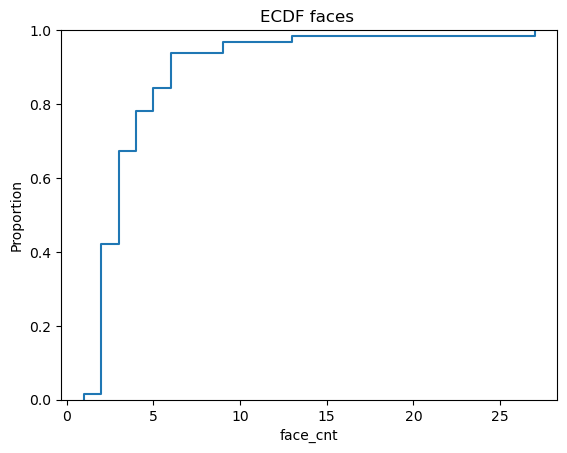

In [10]:
sns.ecdfplot(video_stat_detail_df['face_cnt'])
plt.title("ECDF faces ")
plt.show()

In [11]:
face_cnt_quant_value = video_stat_detail_df['face_cnt'].quantile([0.4, 0.80]).values
print('valori quantili face_cnt==>',face_cnt_quant_value)
#definisci indice bin per face_cnt
video_stat_detail_df['face_cnt_bin'] = np.digitize(video_stat_detail_df['face_cnt'], bins=face_cnt_quant_value, right=True)

valori quantili face_cnt==> [2. 5.]


###  ECDF frame_cnt per video 

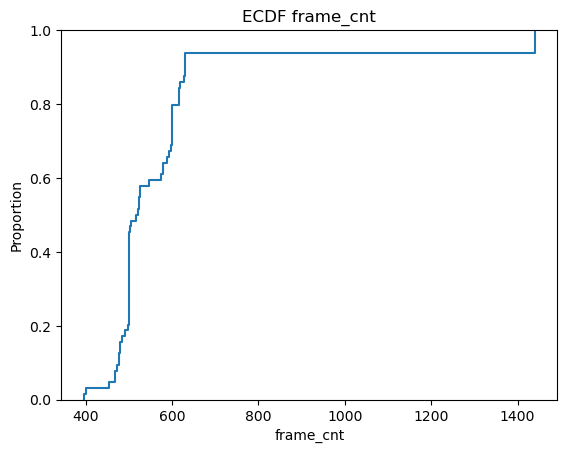

In [12]:
sns.ecdfplot(video_stat_detail_df['frame_cnt'])
plt.title("ECDF frame_cnt")
plt.show()

In [13]:
frame_cnt_quant_value = video_stat_detail_df['frame_cnt'].quantile([0.55,0.85]).values
print('valori quantili frame_cnt==>',frame_cnt_quant_value)
#definisci indice bin per frame_cnt
video_stat_detail_df['frame_cnt_bin'] = np.digitize(video_stat_detail_df['frame_cnt'], bins=frame_cnt_quant_value, right=True)

valori quantili frame_cnt==> [524.3 617.1]


###  ECDF height per video 

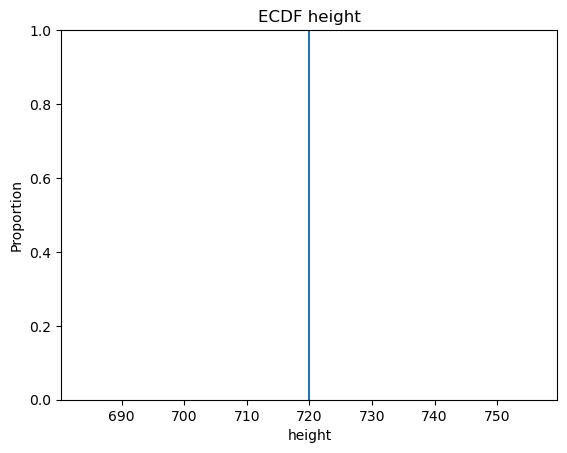

In [14]:
sns.ecdfplot(video_stat_detail_df['height'])
plt.title("ECDF height")
plt.show()

## STEP 1B) SPLIT STRATIFICATO
### OUTPUT ATTESO:  lista video id per training, validation e test mediante campionamento stratificato

In [15]:
TEST_SIZE=0.2
VALIDATION_SIZE=0.2

In [16]:
#colonna identificante del gruppo stratificato
video_stat_detail_df['stratified_key'] = video_stat_detail_df['face_cnt_bin'].astype(str) + "_" + video_stat_detail_df['frame_cnt_bin'].astype(str)
train_val_stat_df, test_stat_df = train_test_split(video_stat_detail_df.loc[:,['stratified_key','video_id']], test_size=TEST_SIZE, stratify=video_stat_detail_df['stratified_key'], random_state=42)
train_stat_df, val_stat_df = train_test_split(train_val_stat_df, test_size=VALIDATION_SIZE, stratify=train_val_stat_df['stratified_key'], random_state=42)

In [17]:
print(f'DATASET (by video-id) LEN ===> TRAIN: {train_stat_df.shape[0]} VAL: {val_stat_df.shape[0]} TEST: {test_stat_df.shape[0]}') 

DATASET (by video-id) LEN ===> TRAIN: 40 VAL: 11 TEST: 13


## STEP 2 
    creazidtypesizionario (input_img_path, output_img_path, video_id, frame_id) di training/validation/test per i seguenti usecase: 
     a) Input: std NON-isotropico  output: mappa gaussiana pesata  (task 1)
     b) Input: std NON-isotropico  output: mappa binaria  (task 2) 
     c) Input: std isotropico  output: mappa gaussiana pesata  (task 1)
     d) Input: std isotropico  output: mappa binaria  (task 2) 
 ### gestione multi task 
     e) Input: std NON-isotropico  output: mappa gaussiana pesata   &  mappa binaria (task 1 & 2)
     f) Input: std isotropico  output: mappa gaussiana pesata   &  mappa binaria (task 1 & 2)

In [18]:
def is_valid_binary_map(path, target_size=(224, 224)):
    """
    Verifica se la mappa binaria contiene almeno un 0 e un 1 dopo il resize.
    """
    if not os.path.exists(path):
        return False

    # Carica l'immagine in scala di grigi
    img = Image.open(path).convert('L')
    img_resized = img.resize(target_size, resample=Image.NEAREST)

    # Converti in array numpy e binarizza (0 e 1)
    np_map = np.array(img_resized)
    binary_map = (np_map > 127).astype(np.uint8)

    has_zero = np.any(binary_map == 0)
    has_one = np.any(binary_map == 1)

    return has_zero and has_one
def downscale_binary_mask(binary_mask_highres=None,path=None,target_size=(224,224)):

    #Proietta i pixel attivi (valore 1) da una mappa binaria ad alta risoluzione
    #su una mappa binaria a risoluzione più bassa, usando coordinate relative.
    if binary_mask_highres is None:  
        binary_mask_highres = Image.open(path).convert('L')
        binary_mask_highres = np.array(binary_mask_highres)
    h_orig, w_orig = binary_mask_highres.shape
    h_target, w_target = target_size

    # Assicura che i pixel attivi siano interpretati come 1
    binary_mask = (binary_mask_highres == 255).astype(np.uint8)

    # Trova coordinate dei pixel attivi
    active_coords = np.argwhere(binary_mask == 1)

    # Calcola coordinate relative e proiettate
    rel_coords = active_coords.astype(np.float32)
    rel_coords[:, 0] = rel_coords[:, 0] / h_orig * h_target  # y
    rel_coords[:, 1] = rel_coords[:, 1] / w_orig * w_target  # x

    # Crea nuova mappa binaria
    binary_mask_lowres = np.zeros((h_target, w_target), dtype=np.uint8)

    # Inserisci pixel attivi nella nuova mappa
    for y, x in rel_coords:
        y_int = int(round(y))
        x_int = int(round(x))
        if 0 <= y_int < h_target and 0 <= x_int < w_target:
            binary_mask_lowres[y_int, x_int] = 1

    return binary_mask_lowres
def calculate_fixation_pixel_cnt(path=None,binary_map=None,pixel_active_value=255):

    if binary_map is None:
        if not os.path.exists(path):
            return False
        # Carica l'immagine in scala di grigi
        img = Image.open(path).convert('L')
        # Converti in array numpy e binarizza (0 e 1)
        binary_map = np.array(img)
    fixation_pixel_cnt = int(np.sum(binary_map == pixel_active_value))
    return fixation_pixel_cnt
def analyze_pixel_values(image_path):
    
    #Analizza i valori dei pixel in un'immagine e conta quanti sono 0, 255 e intermedi.

    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # carica come scala di grigi
    unique, counts = np.unique(img, return_counts=True)
    
    stats = {
        'total_pixels': img.size,
        'zeros': int(np.sum(img == 0)),
        'full_white': int(np.sum(img == 255)),
        'intermediate': int(np.sum((img > 0) & (img < 255))),
        'unique_values': dict(zip(unique.tolist(), counts.tolist()))
    }
    return stats    

In [22]:
BINARY_LOW_RES_SHAPE = (224,224)

In [23]:
usecase_key_list=['nonisotropic__continuous', 'nonisotropic__binary','isotropic__continuous','isotropic__binary','nonisotropic__continuous_binary','isotropic__continuous_binary']

In [24]:
#ottieni lista video id per split
video_ids_all = {'train': {'out_path':TRAIN_DATA_PATH,'video_ids': train_stat_df.video_id.tolist()},
                 'val':{'out_path':VAL_DATA_PATH,'video_ids':val_stat_df.video_id.tolist()},
                 'test':{'out_path':TEST_DATA_PATH,'video_ids':test_stat_df.video_id.tolist()}}
not_valid_after_resize={'tot':0}
for data_mode in video_ids_all.keys():   
    data_path_dict={'mode': data_mode, 'usecase': { case_key:[] for case_key in usecase_key_list } } 
    for video_id in video_ids_all[data_mode]['video_ids']:
        frame_cnt = video_stat_detail_df[video_stat_detail_df['video_id']==str(video_id)]['frame_cnt'].tolist()[0]
        not_valid_after_resize[str(video_id)]=0
        for frame_id in range(frame_cnt):
            NON_ISOTROPIC_INPUT=os.path.join(GAUSSIAN_COVk_INPUT_DATA_PATH,f"{video_id}",f"video{video_id}_frame{frame_id}.png")
            ISOTROPIC_INPUT=os.path.join(GAUSSIAN_ISOk_INPUT_DATA_PATH,f"{video_id}",f"video{video_id}_frame{frame_id}.png")
            CONTINUOUS_OUTPUT = os.path.join(WEIGHT_GAUSSIAN_TARGET_PATH,f"{video_id}",f"video{video_id}_frame{frame_id}_obs38.png")
            BINARY_OUTPUT = os.path.join(BINARY_TARGET_PATH,f"{video_id}",f"video{video_id}_frame{frame_id}_obs38.png")
            BINARY_TARGET_RES224_OUTPUT = os.path.join(BINARY_TARGET_RES224_PATH,f"{video_id}",f"video{video_id}_frame{frame_id}_obs38.png")
            if not os.path.exists(BINARY_OUTPUT): 
             #binary deve esisere perchè servirà per la valutazione dei modelli
             continue 
            """
            if is_valid_binary_map(BINARY_OUTPUT,target_size=(384, 384))==False:
                #print('immagine target non valida per video', video_id, 'frame',frame_id)
                not_valid_after_resize[str(video_id)]+=1
                not_valid_after_resize['tot']+=1
                continue 
            """
            #crea immagine binaria a risoluzione più bassa 
            lower_res_binary_map = downscale_binary_mask(path=BINARY_OUTPUT, target_size=BINARY_LOW_RES_SHAPE)
            fixation_cnt_original_res=calculate_fixation_pixel_cnt(BINARY_OUTPUT,pixel_active_value=255)
            fixation_cnt_lower_res=calculate_fixation_pixel_cnt(binary_map=lower_res_binary_map,pixel_active_value=1)
            if fixation_cnt_lower_res<1:  
                print('0 fixation in low res skip') 
                continue 
            #BINARY_TARGET_RES224_PATH
            binary_target_lowres_dest_folder = os.path.join(BINARY_TARGET_RES224_PATH,f"{video_id}")
            os.makedirs(binary_target_lowres_dest_folder, exist_ok=True)
            uf.export_mask2image(my_mask=lower_res_binary_map,path=BINARY_TARGET_RES224_OUTPUT)
            
            
            
            if os.path.exists(NON_ISOTROPIC_INPUT) and  os.path.exists(CONTINUOUS_OUTPUT): 
                data_path_dict['usecase']['nonisotropic__continuous'].append([NON_ISOTROPIC_INPUT,CONTINUOUS_OUTPUT,BINARY_TARGET_RES224_OUTPUT])
                data_path_dict['usecase']['nonisotropic__continuous_binary'].append([NON_ISOTROPIC_INPUT,CONTINUOUS_OUTPUT,BINARY_TARGET_RES224_OUTPUT])
            if os.path.exists(NON_ISOTROPIC_INPUT):
                data_path_dict['usecase']['nonisotropic__binary'].append([NON_ISOTROPIC_INPUT,BINARY_TARGET_RES224_OUTPUT])
            if os.path.exists(ISOTROPIC_INPUT) and  os.path.exists(CONTINUOUS_OUTPUT): 
                data_path_dict['usecase']['isotropic__continuous'].append([ISOTROPIC_INPUT,CONTINUOUS_OUTPUT,BINARY_TARGET_RES224_OUTPUT])
                data_path_dict['usecase']['isotropic__continuous_binary'].append([ISOTROPIC_INPUT,CONTINUOUS_OUTPUT,BINARY_TARGET_RES224_OUTPUT])
            if os.path.exists(ISOTROPIC_INPUT):
                data_path_dict['usecase']['isotropic__binary'].append([ISOTROPIC_INPUT,BINARY_TARGET_RES224_OUTPUT])
    #salva json per singolo split 
    uf.write_json(data=data_path_dict,path=os.path.join(video_ids_all[data_mode]['out_path'],f'{data_mode}.json'))